<a href="https://colab.research.google.com/github/plipmanbg/QuantumChemistry/blob/main/LiH_Geometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Optimize geometry of LiH**

Follows Pennylane adaptive circuit tutorial to obtain circuit, and molecular geometry tutorial to optimize geometry

In [ ]:
!pip install pennylane &> /dev/null

In [ ]:
!pip install pennylane-qchem &> /dev/null

In [ ]:
from pennylane import numpy as np
import pennylane as qml

In [ ]:
from pennylane import qchem

In [ ]:
# Set up the molecule. Geometry coordinates from CCCBDB

symbols = ["Li", "H"]
geometry = np.array([0.0,0.0,0.0,0.0,0.0,3.064], requires_grad=True)

Now create the circuit using https://pennylane.ai/qml/demos/tutorial_adaptive_circuits.html

First - compute the Hamiltonian and calculate the single and double electron excitations (maybe also try looking at 3 & 4 excitations to see what effect it has on accuracy?).

In [ ]:
active_electrons = 2
active_orbitals = 5

H, qubits = qchem.molecular_hamiltonian(
    symbols,
    geometry,
    active_electrons=active_electrons, # figure out how to get this
    active_orbitals=active_orbitals # figure out how to get this
)

singles, doubles = qchem.excitations(active_electrons, qubits)

In [ ]:
print(qubits)

10


In [ ]:
print(singles)

[[0, 2], [0, 4], [0, 6], [0, 8], [1, 3], [1, 5], [1, 7], [1, 9]]


In [ ]:
print(doubles)

[[0, 1, 2, 3], [0, 1, 2, 5], [0, 1, 2, 7], [0, 1, 2, 9], [0, 1, 3, 4], [0, 1, 3, 6], [0, 1, 3, 8], [0, 1, 4, 5], [0, 1, 4, 7], [0, 1, 4, 9], [0, 1, 5, 6], [0, 1, 5, 8], [0, 1, 6, 7], [0, 1, 6, 9], [0, 1, 7, 8], [0, 1, 8, 9]]


Get the Hartree-Fock state

In [ ]:
hf_state = qchem.hf_state(active_electrons, qubits)
print(hf_state)

[1 1 0 0 0 0 0 0 0 0]


Build the circuit:



1.   Compute gradients for all double excitations
2.   Select the double excitations with 
gradients larger than a pre-defined threshold

1.   Select the double excitations with 
gradients larger than a pre-defined threshold
2.   Perform VQE to obtain the optimized parameters for the selected double excitations

1.   Repeat steps 1 and 2 for the single excitations

In [ ]:
# This function builds the circuit based on the set of parameters passed below
# Wires - i.e. qubits in the circuit, and specific qubit excitations

def circuit_1(params, wires, excitations):

    qml.BasisState(hf_state, wires=wires)

    for i, excitation in enumerate(excitations):
        if len(excitation) == 4: #double excitations have four entries
            qml.DoubleExcitation(params[i], wires=excitation)
        else:
            qml.SingleExcitation(params[i], wires=excitation) #two entries each

In [ ]:
# specify the device
dev = qml.device("default.qubit", wires=qubits)

# cost function calculate the expectation value of the Hamiltonian based on the
# ansatz which is the circuit
cost_fn = qml.ExpvalCost(circuit_1, H, dev, optimize=True)

# # get the gradient of the cost function
circuit_gradient = qml.grad(cost_fn, argnum=0)

# # initialize parameters to zero so gradients computed from HF state
params = [0.0] * len(doubles)

# #calculate the gradient for the double excitations
# this one actually calls the circuit_1 function
grads = circuit_gradient(params, excitations=doubles)

for i in range(len(doubles)):
    print(f"Excitation : {doubles[i]}, Gradient: {grads[i]}")

Excitation : [0, 1, 2, 3], Gradient: -0.013282692971956422
Excitation : [0, 1, 2, 5], Gradient: -2.1684043449710084e-19
Excitation : [0, 1, 2, 7], Gradient: 3.2526065174565114e-19
Excitation : [0, 1, 2, 9], Gradient: 0.03486133571916371
Excitation : [0, 1, 3, 4], Gradient: 4.065758146820643e-20
Excitation : [0, 1, 3, 6], Gradient: -1.3552527156068803e-19
Excitation : [0, 1, 3, 8], Gradient: -0.034861335719163965
Excitation : [0, 1, 4, 5], Gradient: -0.02330625477597942
Excitation : [0, 1, 4, 7], Gradient: 0.0
Excitation : [0, 1, 4, 9], Gradient: 0.0
Excitation : [0, 1, 5, 6], Gradient: 0.0
Excitation : [0, 1, 5, 8], Gradient: 2.1684043449710118e-19
Excitation : [0, 1, 6, 7], Gradient: -0.02330625477597944
Excitation : [0, 1, 6, 9], Gradient: 0.0
Excitation : [0, 1, 7, 8], Gradient: -1.8973538018496287e-19
Excitation : [0, 1, 8, 9], Gradient: -0.12416373075295714


In [ ]:
# Just keep the double excitations that have gradients > 10^-5

doubles_select = [doubles[i] for i in range(len(doubles)) if abs(grads[i]) > 1.0e-5]
doubles_select

[[0, 1, 2, 3],
 [0, 1, 2, 9],
 [0, 1, 3, 8],
 [0, 1, 4, 5],
 [0, 1, 6, 7],
 [0, 1, 8, 9]]

In [ ]:
# Calculate the parameters (params_doubles) for each of the double excitation gates
# using gradient descent to find the lowest expectation value of H on circuit_1
# having applied the selected double excitations

opt = qml.GradientDescentOptimizer(stepsize=0.5)

params_doubles = np.zeros(len(doubles_select), requires_grad=True)

for n in range(20):
    params_doubles = opt.step(cost_fn, params_doubles, excitations=doubles_select)

In [ ]:
# Create new circuit that applies the selected gates based on the gradients
# determined above gradient threshold and pass those gates the parameters
# calculated in the GDO process

def circuit_2(params, wires, excitations, gates_select, params_select):
    qml.BasisState(hf_state, wires=wires)

    # apply the selected gates and apply parameters
    
    for i, gate in enumerate(gates_select):
        if len(gate) == 4:
            qml.DoubleExcitation(params_select[i], wires=gate)
        elif len(gate) == 2:
            qml.SingleExcitation(params_select[i], wires=gate)

    for i, gate in enumerate(excitations):
        if len(gate) == 4:
            qml.DoubleExcitation(params[i], wires=gate)
        elif len(gate) == 2:
            qml.SingleExcitation(params[i], wires=gate)

In [ ]:
# Now compute gradients for single excitations, in same way we did for the
# double excitations

# cost function calculate the expectation value of the Hamiltonian based on the
# ansatz which is the circuit
cost_fn = qml.ExpvalCost(circuit_2, H, dev, optimize=True)

# get the gradient of the cost function
circuit_gradient = qml.grad(cost_fn, argnum=0)

# initialize parameters to zero so gradients computed from HF state
# note that we're only doing this for the single excitations as the 
# doubles are already fixed
params = [0.0] * len(singles)

# calculate the gradient for the single excitations, but with the previously
# computed double excitations held constant. Note that circuit_2 takes the
# following parameters: params, wires, excitations, gates_select, params_select

grads = circuit_gradient(
    params,
    excitations=singles,
    gates_select = doubles_select,
    params_select = params_doubles)

for i in range(len(singles)):
    print(f"Excitation : {singles[i]}, Gradient: {grads[i]}")

Excitation : [0, 2], Gradient: -0.005146190384624545
Excitation : [0, 4], Gradient: -1.4675863503195058e-17
Excitation : [0, 6], Gradient: 7.690800194090734e-19
Excitation : [0, 8], Gradient: -0.000980381946160425
Excitation : [1, 3], Gradient: 0.004997627978515387
Excitation : [1, 5], Gradient: -5.784431962375564e-19
Excitation : [1, 7], Gradient: -3.0538143873782976e-18
Excitation : [1, 9], Gradient: 0.0015198027890503626


In [ ]:
singles_select = [singles[i] for i in range(len(singles)) if abs(grads[i]) > 1.0e-5]
singles_select

[[0, 2], [0, 8], [1, 3], [1, 9]]

In [ ]:
excitations = doubles_select + singles_select
excitations

[[0, 1, 2, 3],
 [0, 1, 2, 9],
 [0, 1, 3, 8],
 [0, 1, 4, 5],
 [0, 1, 6, 7],
 [0, 1, 8, 9],
 [0, 2],
 [0, 8],
 [1, 3],
 [1, 9]]

In [ ]:
cost_fn = qml.ExpvalCost(circuit_1, H, dev, optimize=True)

params = np.zeros(len(doubles_select + singles_select), requires_grad=True)

gates_select = doubles_select + singles_select

for n in range(20):
    params, energy = opt.step_and_cost(cost_fn, params, excitations=gates_select)
    print("n = {:},  E = {:.8f} H".format(n, energy))

n = 0,  E = -7.86109478 H
n = 1,  E = -7.86949977 H
n = 2,  E = -7.87434711 H
n = 3,  E = -7.87715002 H
n = 4,  E = -7.87878428 H
n = 5,  E = -7.87974964 H
n = 6,  E = -7.88032993 H
n = 7,  E = -7.88068655 H
n = 8,  E = -7.88091179 H
n = 9,  E = -7.88105877 H
n = 10,  E = -7.88115837 H
n = 11,  E = -7.88122874 H
n = 12,  E = -7.88128070 H
n = 13,  E = -7.88132074 H
n = 14,  E = -7.88135286 H
n = 15,  E = -7.88137955 H
n = 16,  E = -7.88140237 H
n = 17,  E = -7.88142234 H
n = 18,  E = -7.88144014 H
n = 19,  E = -7.88145621 H


In [ ]:
params

tensor([ 0.0530969 , -0.1060742 ,  0.10604959,  0.05275959,  0.05277617,
         0.2361398 ,  0.02649252,  0.00483553, -0.02614315, -0.00459074], requires_grad=True)

**Now we do the geometry and energy optimization**


In [ ]:
x = np.array([0.0,0.0,0.0,0.0,0.0,3.064], requires_grad=True)

In [ ]:
# Get the Hamiltonian for the molecule, based on x (position of nuclei)
# This is different from the earlier code where we weren't changing positions

def H(x):
    return qml.qchem.molecular_hamiltonian(symbols,
                                           x,
                                           active_electrons=active_electrons, # figure out how to get this
                                           active_orbitals=active_orbitals, # figure out how to get this
                                           charge=0)[0]

In [ ]:
# we made the HF state earlier, doing it here again

hf = qchem.hf_state(active_electrons, qubits)
print(hf)

[1 1 0 0 0 0 0 0 0 0]


In [ ]:
print(qubits)

10


In [ ]:
num_wires = qubits
dev = qml.device("default.qubit", wires=num_wires)
print(num_wires)

10


In [ ]:
@qml.qnode(dev)
def circuit(params, obs, wires):
    qml.BasisState(hf, wires=wires)

    #added this code, replacing hard-coded excitations in tutorial

    for i, excitation in enumerate(excitations):
        if len(excitation) == 4:
            qml.DoubleExcitation(params[i], wires=excitation)
        else:
            qml.SingleExcitation(params[i], wires=excitation) 
    
    return qml.expval(obs)

In [ ]:
# Get the expectation value of the Hamiltonian, based on the excitation
# parameters and the x (position) value. A call to 'circuit' returns
# the expectation value of measuring the Hamiltonian

# NOTE: find a way to not have to pass the excitations each time?

def cost(params, x):
    hamiltonian = H(x)
    return circuit(params, obs=hamiltonian, wires=range(num_wires))

Explanation of [qml.finite_diff](https://pennylane.readthedocs.io/en/stable/code/api/pennylane.finite_diff.html#pennylane.finite_diff)

In [ ]:
# Find the partial differential of H w.r.t. x

def grad_x(params, x):
    grad_h = qml.finite_diff(H)(x)
    grad = [circuit(params, obs=obs, wires=range(num_wires)) for obs in grad_h]
    return np.array(grad)

In [ ]:
# Experiment with different step sizes?

opt_theta = qml.GradientDescentOptimizer(stepsize=0.4)
opt_x = qml.GradientDescentOptimizer(stepsize=0.8)

In [ ]:
theta = np.zeros(len(excitations), requires_grad=True)
len(theta)

10

In [ ]:
from functools import partial

# store the values of the cost function
energy = []

# store the values of the bond length
bond_length = []

# Factor to convert from Bohrs to Angstroms
bohr_angs = 0.529177210903

In [ ]:
for n in range(100):

    # Optimize the circuit parameters
    theta.requires_grad = True
    x.requires_grad = False
    theta, _ = opt_theta.step(cost, theta, x)

    # Optimize the nuclear coordinates
    x.requires_grad = True
    theta.requires_grad = False
    _, x = opt_x.step(cost, theta, x, grad_fn=grad_x)

    energy.append(cost(theta, x))
    bond_length.append(np.linalg.norm(x[0:3] - x[3:6]) * bohr_angs)

    if n % 4 == 0:
        print(f"Step = {n},  E = {energy[-1]:.8f} Ha,  bond length = {bond_length[-1]:.5f} A")

    # Check maximum component of the nuclear gradient
    if np.max(grad_x(theta, x)) <= 1e-05:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" "Ground-state equilibrium geometry")
print("%s %4s %8s %8s" % ("symbol", "x", "y", "z"))
for i, atom in enumerate(symbols):
    print(f"  {atom}    {x[3 * i]:.4f}   {x[3 * i + 1]:.4f}   {x[3 * i + 2]:.4f}")

Step = 0,  E = -7.86860562 Ha,  bond length = 1.60439 A
Step = 4,  E = -7.87982617 Ha,  bond length = 1.56358 A
Step = 8,  E = -7.88172074 Ha,  bond length = 1.54899 A
Step = 12,  E = -7.88211287 Ha,  bond length = 1.54475 A
Step = 16,  E = -7.88224069 Ha,  bond length = 1.54401 A
Step = 20,  E = -7.88230766 Ha,  bond length = 1.54429 A
Step = 24,  E = -7.88235358 Ha,  bond length = 1.54477 A
Step = 28,  E = -7.88238863 Ha,  bond length = 1.54520 A
Step = 32,  E = -7.88241646 Ha,  bond length = 1.54555 A
Step = 36,  E = -7.88243890 Ha,  bond length = 1.54582 A
Step = 40,  E = -7.88245710 Ha,  bond length = 1.54603 A
Step = 44,  E = -7.88247192 Ha,  bond length = 1.54619 A
Step = 48,  E = -7.88248400 Ha,  bond length = 1.54633 A
Step = 52,  E = -7.88249385 Ha,  bond length = 1.54644 A
Step = 56,  E = -7.88250189 Ha,  bond length = 1.54653 A
Step = 60,  E = -7.88250845 Ha,  bond length = 1.54661 A
Step = 64,  E = -7.88251381 Ha,  bond length = 1.54669 A
Step = 68,  E = -7.88251819 Ha,  b

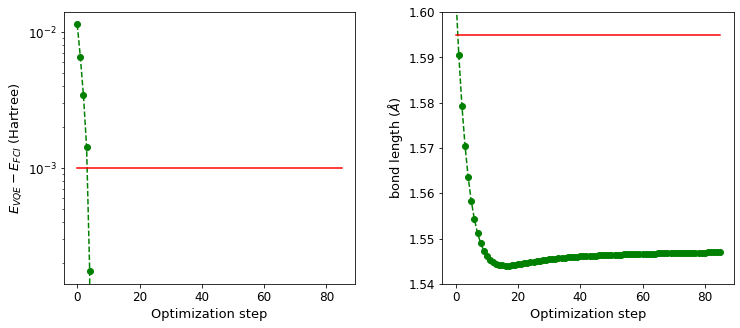

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Add energy plot on column 1
E_fci = -7.88
E_vqe = np.array(energy)
ax1 = fig.add_subplot(121)
ax1.plot(range(n+1), E_vqe-E_fci, 'go-', ls='dashed')
ax1.plot(range(n+1), np.full(n+1, 0.001), color='red')
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("$E_{VQE} - E_{FCI}$ (Hartree)", fontsize=13)
# ax1.text(5, 0.0013, r'Chemical accuracy', fontsize=13)
plt.yscale("log")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add bond length plot on column 2
d_fci = 1.595 # https://cccbdb.nist.gov/bondlengthmodel2.asp?method=12&basis=5
ax2 = fig.add_subplot(122)
ax2.plot(range(n+1), bond_length, 'go-', ls='dashed')
ax2.plot(range(n+1), np.full(n+1, d_fci), color='red')
ax2.set_ylim([1.54,1.6])
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("bond length ($\AA$)", fontsize=13)
# ax2.text(5, 0.9865, r'Equilibrium bond length', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3)
plt.show()